In [7]:
import sys
import matplotlib as m

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from absl import app
from absl import flags

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_lattice as tfl

[INFO] [2020-07-23 16:38:57,699] [AAV] - Instantiated @ AAV


Text(0.5, 1.0, 'vf')

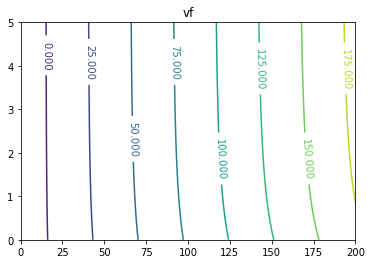

In [8]:
from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

p = Parameters()
aav= AAV(p)
ws = np.linspace(0, 200, 100)
ls = np.linspace(0, 5, 100)
ww, ll = np.meshgrid(ws, ls)
z = np.zeros_like(ww)
features = []
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        z[j, i] = -aav.u(ly + 3, wx) - 15
        features.append([ly,wx, z[j, i]])
        
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('vf')

In [9]:
inputs = keras.Input(shape=(2,))
dense = tf.keras.layers.Dense(64, activation="relu")
x = dense(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [10]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [11]:
dataset = pd.DataFrame(features, columns=['l', 'w', 'target'])
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.target.copy()
test_labels = test_dataset.target.copy()
train_dataset = train_dataset.drop(labels=['target'], axis=1)
test_dataset = test_dataset.drop(labels=['target'], axis=1)

In [12]:
EPOCHS = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
historym = model.fit(train_dataset.to_numpy(), train_labels.to_numpy(), epochs=EPOCHS, validation_split = 0.2, verbose=True, callbacks=[callback])

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 1s 103us/sample - loss: 517.2492 - mean_absolute_percentage_error: 95.4821 - val_loss: 37.9002 - val_mean_absolute_percentage_error: 51.5717
Epoch 2/100
6400/6400 [==============================] - 0s 36us/sample - loss: 27.9103 - mean_absolute_percentage_error: 70.2090 - val_loss: 24.4587 - val_mean_absolute_percentage_error: 34.5782
Epoch 3/100
6400/6400 [==============================] - 0s 33us/sample - loss: 19.9753 - mean_absolute_percentage_error: 57.1333 - val_loss: 16.5768 - val_mean_absolute_percentage_error: 25.4704
Epoch 4/100
6400/6400 [==============================] - 0s 34us/sample - loss: 9.1404 - mean_absolute_percentage_error: 27.7019 - val_loss: 3.3218 - val_mean_absolute_percentage_error: 7.2353
Epoch 5/100
6400/6400 [==============================] - 0s 37us/sample - loss: 1.4030 - mean_absolute_percentage_error: 6.2475 - val_loss: 0.5787 - val_mean_absolute_pe

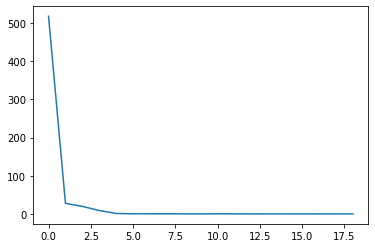

In [13]:
plt.plot(historym.history['loss'])

Text(0.5, 1.0, 'Monotonic')

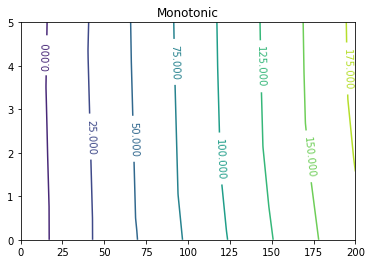

In [14]:
nnm_pred = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        nnm_pred[j, i] = model.predict_on_batch(obs[None,:])
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, nnm_pred)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Monotonic')

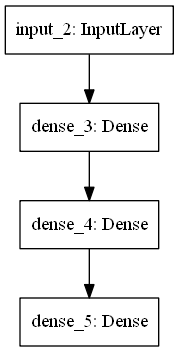

In [15]:
keras.utils.plot_model(model, "my_first_model.png")

One layer lattice with calibrator for input and output

In [43]:
combined_calibrators = []
    
max_l = 5
max_w = 200

n_lattice_points = [40, 40]

tf.keras.backend.set_floatx('float64')

calibration_layer_l = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_l, num=800), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0, 
                                                monotonicity='increasing', convexity='concave')
calibration_layer_w = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_w, num=800), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0,
                                                monotonicity='increasing', convexity='convex')
combined_calibrators.append(calibration_layer_l)
combined_calibrators.append(calibration_layer_w)
    
input_callibrators = tfl.layers.ParallelCombination(combined_calibrators, single_output=True)   

inputs = keras.Input(shape=(2,))
calibrator1 = input_callibrators(inputs)
lattice1 = tfl.layers.Lattice(units=1, lattice_sizes=n_lattice_points, monotonicities=['increasing'] * 2, output_min=0, output_max=1)(calibrator1)
calibrator2 = tfl.layers.PWLCalibration(units=1, input_keypoints=np.linspace(0, 1, 800), dtype=tf.float32, output_min=0, output_max=max_w, monotonicity='increasing')(lattice1)
model = keras.Model(inputs=inputs, outputs=calibrator2, name="calibrator2")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam', metrics=['mean_absolute_percentage_error'])


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[WARNING] [2020-07-23 16:53:34,387] [tensorflow] - Layer lattice_7 is casting an input tensor from dtype float32 to the layer's dtype of float64, which is new behavior in TensorFlow 2.  The layer has dtype float64 because it's dtype defaults to floatx.

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `t

In [44]:
obs = np.array([1., 100.])
model(obs[None, :])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[69.99998]], dtype=float32)>

In [45]:
model.summary()

Model: "calibrator2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
parallel_combination_15 (Par (None, 2)                 1600      
_________________________________________________________________
lattice_7 (Lattice)          (None, 1)                 1600      
_________________________________________________________________
pwl_calibration_40 (PWLCalib (None, 1)                 800       
Total params: 4,000
Trainable params: 4,000
Non-trainable params: 0
_________________________________________________________________


In [47]:
EPOCHS = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
historym = model.fit(train_dataset.to_numpy(), train_labels.to_numpy(), epochs=EPOCHS, validation_split = 0.2, verbose=True, callbacks=[callback])

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 2s 284us/sample - loss: 6.7442 - mean_absolute_percentage_error: 10.2052 - val_loss: 7.3161 - val_mean_absolute_percentage_error: 9.6500
Epoch 2/100
6400/6400 [==============================] - 2s 282us/sample - loss: 6.8242 - mean_absolute_percentage_error: 10.3847 - val_loss: 7.3271 - val_mean_absolute_percentage_error: 9.6427
Epoch 3/100
6400/6400 [==============================] - 2s 282us/sample - loss: 6.7517 - mean_absolute_percentage_error: 10.2029 - val_loss: 7.3018 - val_mean_absolute_percentage_error: 9.5670
Epoch 4/100
6400/6400 [==============================] - 2s 272us/sample - loss: 6.7492 - mean_absolute_percentage_error: 10.2100 - val_loss: 7.2930 - val_mean_absolute_percentage_error: 9.5426


Text(0.5, 1.0, 'Monotonic')

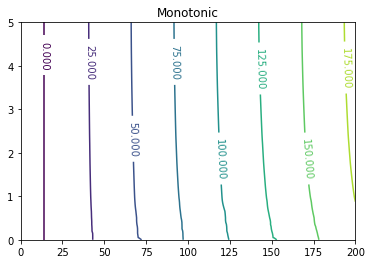

In [48]:
nnm_pred = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        nnm_pred[j, i] = model.predict_on_batch(obs[None,:])
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, nnm_pred)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Monotonic')

Text(0.5, 1.0, 'Monotonic')

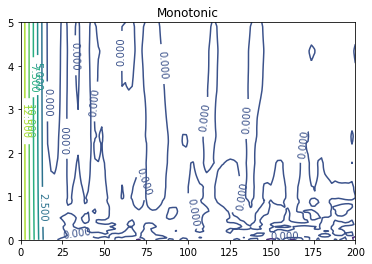

In [49]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, nnm_pred-z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Monotonic')

In [53]:
z

array([[-15.        , -13.13017532, -11.26035064, ..., 166.37299399,
        168.24281868, 170.11264336],
       [-15.        , -13.12635743, -11.25271485, ..., 166.7433297 ,
        168.61697227, 170.49061485],
       [-15.        , -13.12267383, -11.24534766, ..., 167.10063865,
        168.97796482, 170.85529099],
       ...,
       [-15.        , -13.01413461, -11.02826922, ..., 177.62894306,
        179.61480845, 181.60067384],
       [-15.        , -13.0138634 , -11.02772679, ..., 177.65525062,
        179.64138723, 181.62752383],
       [-15.        , -13.01359707, -11.02719415, ..., 177.68108388,
        179.6674868 , 181.65388973]])

Functional model with two separated lattice streams each for one output

In [16]:
combined_calibrators = []
    
max_l = 5
max_w = 200

n_lattice_points = [2, 2]

for i in range(2):
    calibration_layer_l = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_l, num=200), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0, 
                                                    monotonicity='increasing', convexity='concave')
    calibration_layer_w = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_w, num=200), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0,
                                                    monotonicity='increasing', convexity='convex')
    combined_calibrators.append(calibration_layer_l)
    combined_calibrators.append(calibration_layer_w)
    
input_callibrators = tfl.layers.ParallelCombination(combined_calibrators, single_output=True)   

In [26]:
inputs = keras.Input(shape=(2,))
repeated_input = keras.layers.RepeatVector(2)(inputs)
repeated_input = keras.layers.Flatten()(repeated_input)
calibrator1 = input_callibrators(repeated_input)
calibrator1 = keras.layers.Reshape((2, 2))(calibrator1)
lattice1 = tfl.layers.Lattice(units=2, lattice_sizes=[2, 2], monotonicities=['increasing']*2, output_min=0, output_max=1)(calibrator1)
calibrator2 = tfl.layers.PWLCalibration(units=2, input_keypoints=np.linspace(0, 1, 100), dtype=tf.float32, output_min=0, output_max=1, monotonicity='increasing')(lattice1)
lattice2 = tfl.layers.Lattice(units=1, lattice_sizes=[2, 2], monotonicities=['increasing']*2, output_min=0, output_max=1)(calibrator2)
calibrator3 = tfl.layers.PWLCalibration(units=1, input_keypoints=np.linspace(0, 1, 100), dtype=tf.float32, monotonicity='increasing')(lattice2)
model = keras.Model(inputs=inputs, outputs=calibrator3, name="calibrator2")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [27]:
obs = np.array([1., 100.])
model(obs[None, :])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[WARNING] [2020-07-19 21:17:21,663] [tensorflow] - Layer repeat_vector_2 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, c

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

In [28]:
model.summary()

Model: "calibrator2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 2, 2)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4)                 0         
_________________________________________________________________
parallel_combination_2 (Para (None, 4)                 800       
_________________________________________________________________
reshape_2 (Reshape)          (None, 2, 2)              0         
_________________________________________________________________
lattice_4 (Lattice)          (None, 2)                 8         
_________________________________________________________________
pwl_calibration_16 (PWLCalib (None, 2)                 

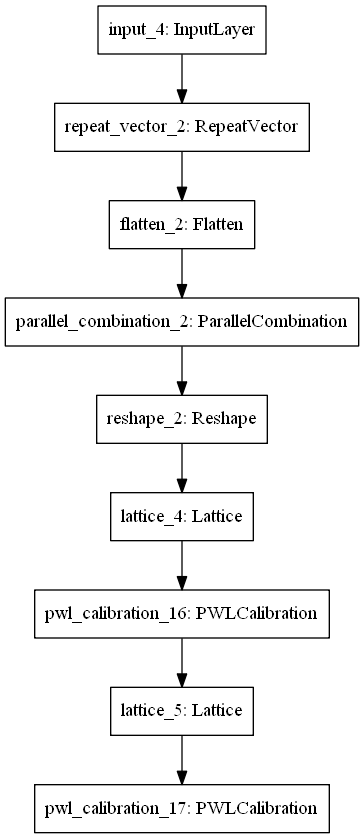

In [29]:
keras.utils.plot_model(model, "my_first_model.png")

In [33]:
EPOCHS = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
historym = model.fit(train_dataset.to_numpy(), train_labels.to_numpy(), epochs=EPOCHS, validation_split = 0.2, verbose=True, callbacks=[callback])

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 1s 120us/sample - loss: 7.0449 - mean_absolute_percentage_error: 11.2623 - val_loss: 8.3398 - val_mean_absolute_percentage_error: 10.2565
Epoch 2/100
6400/6400 [==============================] - 1s 119us/sample - loss: 7.4751 - mean_absolute_percentage_error: 10.3852 - val_loss: 7.1343 - val_mean_absolute_percentage_error: 11.6217
Epoch 3/100
6400/6400 [==============================] - 1s 118us/sample - loss: 6.4802 - mean_absolute_percentage_error: 9.6913 - val_loss: 7.0510 - val_mean_absolute_percentage_error: 9.4975
Epoch 4/100
6400/6400 [==============================] - 1s 120us/sample - loss: 6.4668 - mean_absolute_percentage_error: 9.8947 - val_loss: 6.5051 - val_mean_absolute_percentage_error: 9.4309
Epoch 5/100
6400/6400 [==============================] - 1s 119us/sample - loss: 6.2720 - mean_absolute_percentage_error: 9.7680 - val_loss: 7.1795 - val_mean_absolute_percenta

Text(0.5, 1.0, 'Monotonic')

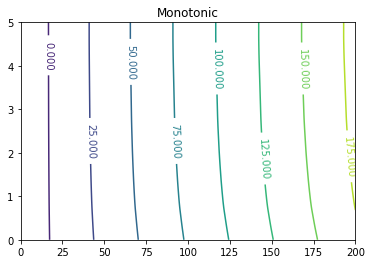

In [34]:
nnm_pred = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        nnm_pred[j, i] = model.predict_on_batch(obs[None,:])
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, nnm_pred)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Monotonic')

Text(0.5, 1.0, 'Monotonic')

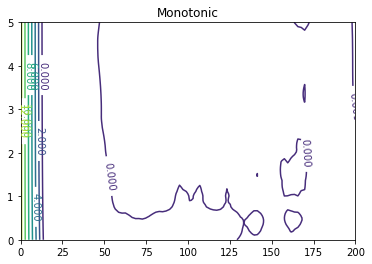

In [35]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, nnm_pred-z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Monotonic')

Lets try a deeper model

In [57]:
combined_calibrators = []
    
max_l = 5
max_w = 200

lattice_units_layer = [4, 4, 1]

n_lattice_points=[5, 5, 5]

for i in range(lattice_units_layer[0]):
    calibration_layer_l = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_l, num=400), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0, 
                                                    monotonicity='increasing', convexity='concave')
    calibration_layer_w = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_w, num=400), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0,
                                                    monotonicity='increasing', convexity='convex')
    combined_calibrators.append(calibration_layer_l)
    combined_calibrators.append(calibration_layer_w)
    
input_callibrators = tfl.layers.ParallelCombination(combined_calibrators, single_output=True)   

In [58]:
inputs = keras.Input(shape=(2,))
repeated_input = keras.layers.RepeatVector(lattice_units_layer[0])(inputs)
repeated_input = keras.layers.Flatten()(repeated_input)
calibrator1 = input_callibrators(repeated_input)
calibrator1 = keras.layers.Reshape((lattice_units_layer[0], 2))(calibrator1)
lattice1 = tfl.layers.Lattice(units=lattice_units_layer[0], lattice_sizes=[n_lattice_points[0]]*2, monotonicities=2*['increasing'], output_min=0, output_max=1)(calibrator1)
lattice1 = keras.layers.RepeatVector(lattice_units_layer[1])(lattice1)
lattice1 = keras.layers.Flatten()(lattice1)
calibrator2 =tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, 1, num=50),units=lattice_units_layer[0] * lattice_units_layer[1],dtype=tf.float32,output_min=0.0,output_max=n_lattice_points[1] - 1.0, 
                                       monotonicity='increasing')(lattice1)
calibrator2 = keras.layers.Reshape((lattice_units_layer[1], lattice_units_layer[0]))(calibrator2)

lattice2 = tfl.layers.Lattice(units=lattice_units_layer[1], lattice_sizes=[n_lattice_points[1]]*lattice_units_layer[0], monotonicities=['increasing']*lattice_units_layer[0], output_min=0, output_max=1)(calibrator2)
calibrator3 = tfl.layers.PWLCalibration(units=lattice_units_layer[1] * lattice_units_layer[2], input_keypoints=np.linspace(0, 1, 100), dtype=tf.float32, monotonicity='increasing', output_min=0, output_max=1)(lattice2)

lattice3 = tfl.layers.Lattice(units=lattice_units_layer[2], lattice_sizes=[n_lattice_points[2]]*lattice_units_layer[1], monotonicities=['increasing']*lattice_units_layer[0], output_min=0, output_max=1)(calibrator3)

calibratorf = tfl.layers.PWLCalibration(units=lattice_units_layer[2], input_keypoints=np.linspace(0, 1, 100), dtype=tf.float32, monotonicity='increasing')(lattice3)

model = keras.Model(inputs=inputs, outputs=calibratorf, name="calibrator2")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [59]:
obs = np.array([1., 100.])
model(obs[None, :])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[WARNING] [2020-07-19 21:27:16,284] [tensorflow] - Layer repeat_vector_9 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, c

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

In [60]:
model.summary()

Model: "calibrator2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 4, 2)              0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8)                 0         
_________________________________________________________________
parallel_combination_6 (Para (None, 8)                 3200      
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 2)              0         
_________________________________________________________________
lattice_15 (Lattice)         (None, 4)                 100       
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 4, 4)              

In [63]:
EPOCHS = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
historym = model.fit(train_dataset.to_numpy(), train_labels.to_numpy(), epochs=EPOCHS, validation_split = 0.2, verbose=True, callbacks=[callback])

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 3s 486us/sample - loss: 23.8775 - mean_absolute_percentage_error: 28.3181 - val_loss: 16.2736 - val_mean_absolute_percentage_error: 23.5733
Epoch 2/100
6400/6400 [==============================] - 3s 463us/sample - loss: 26.0114 - mean_absolute_percentage_error: 30.9192 - val_loss: 11.9601 - val_mean_absolute_percentage_error: 19.4812
Epoch 3/100
6400/6400 [==============================] - 3s 453us/sample - loss: 11.1290 - mean_absolute_percentage_error: 22.8065 - val_loss: 11.1819 - val_mean_absolute_percentage_error: 18.0202
Epoch 4/100
6400/6400 [==============================] - 4s 554us/sample - loss: 10.6938 - mean_absolute_percentage_error: 22.4599 - val_loss: 11.0365 - val_mean_absolute_percentage_error: 17.8135
Epoch 5/100
6400/6400 [==============================] - 3s 459us/sample - loss: 10.1709 - mean_absolute_percentage_error: 21.3960 - val_loss: 10.8338 - val_mean_ab

Text(0.5, 1.0, 'Monotonic')

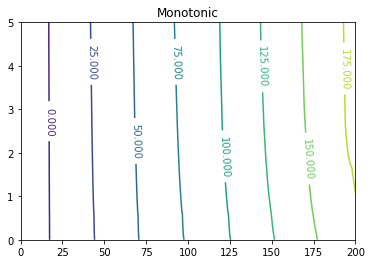

In [66]:
nnm_pred = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        nnm_pred[j, i] = model.predict_on_batch(obs[None,:])
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, nnm_pred)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Monotonic')


Text(0.5, 1.0, 'Monotonic')

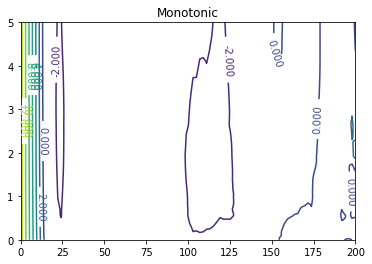

In [67]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, nnm_pred - z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Monotonic')

Let's try a canned estimator

In [70]:
from tensorflow import feature_column as fc
feature_columns = [fc.numeric_column('lambda'),
    fc.numeric_column('w')]

In [75]:
feature_configs = [tfl.configs.FeatureConfig(name='lambda',lattice_size=3,pwl_calibration_num_keypoints=200),
    tfl.configs.FeatureConfig(
        name='w',
        pwl_calibration_num_keypoints=200,
        monotonicity='increasing')]

In [76]:
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=feature_configs)

In [ ]:
tfl.configs.CalibratedLatticeConfig(
    feature_configs=None, interpolation='hypercube', regularizer_configs=None,
    output_min=None, output_max=None, output_calibration=False,
    output_calibration_num_keypoints=10, output_initialization='quantiles'
)

## Learn Q

In [77]:
from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

def transform(x):
    # return ((x*0.8 - 2) + 700)
    return x * 0.1 - 2
aav= AAV(p)
ws = np.linspace(0, 200, 100)
ls = np.linspace(0, 5, 100)
ww, ll = np.meshgrid(ws, ls)
z = np.zeros_like(ww)
zt = np.zeros_like(ww)
features = []
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        z[j, i] = -aav.u(ly, wx)
        zt[j, i] = -aav.u(ly + 3, wx) - 15
        features.append([ly,wx, z[j, i], zt[j, i]])

[INFO] [2020-07-19 21:46:44,091] [AAV] - Instantiated @ AAV


Text(0.5, 1.0, 'vf')

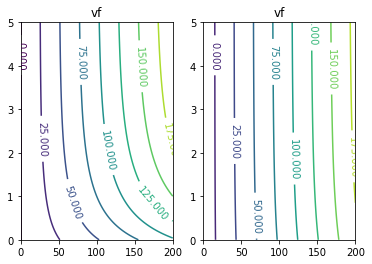

In [78]:
fig, ax = plt.subplots(ncols=2, nrows=1)
CS = ax[0].contour(ww, ll, z)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('vf')
CS = ax[1].contour(ww, ll, zt)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('vf')

In [79]:
dataset = pd.DataFrame(features, columns=['l', 'w', 'target', 'target2'])
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset[['target', 'target2']].copy()
test_labels = test_dataset[['target', 'target2']].copy()
train_dataset = train_dataset.drop(labels=['target', 'target2'], axis=1)
test_dataset = test_dataset.drop(labels=['target', 'target2'], axis=1)

In [80]:
combined_calibratorsl = []
combined_calibratorsr = []

max_l = 5
max_w = 200

lattice_units_layer = [4, 4, 1]

n_lattice_points=[5, 5, 5]

for i in range(lattice_units_layer[0]):
    calibration_layer_l_l = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_l, num=200), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0, 
                                                    monotonicity='increasing',convexity='concave')
    calibration_layer_w_l = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_w, num=200), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0,
                                                    monotonicity='increasing', convexity='convex')
    calibration_layer_l_r = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_l, num=200), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0, 
                                                    monotonicity='increasing', convexity='concave')
    calibration_layer_w_r = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_w, num=200), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0,
                                                    monotonicity='increasing', convexity='convex')
    
    combined_calibratorsl.append(calibration_layer_l_l)
    combined_calibratorsl.append(calibration_layer_w_l)
    
    combined_calibratorsr.append(calibration_layer_l_r)
    combined_calibratorsr.append(calibration_layer_w_r)
    
    
input_callibratorsl = tfl.layers.ParallelCombination(combined_calibratorsl, single_output=True)   
input_callibratorsr = tfl.layers.ParallelCombination(combined_calibratorsr, single_output=True)    

In [81]:
inputs = keras.Input(shape=(2,))
repeated_input = keras.layers.RepeatVector(lattice_units_layer[0])(inputs)
repeated_input = keras.layers.Flatten()(repeated_input)
# left tree
calibrator1l = input_callibratorsl(repeated_input)
calibrator1l = keras.layers.Reshape((lattice_units_layer[0], 2))(calibrator1l)
lattice1l = tfl.layers.Lattice(units=lattice_units_layer[0], lattice_sizes=[n_lattice_points[0]]*2, monotonicities=2*['increasing'], output_min=0, output_max=1)(calibrator1l)
lattice1l = keras.layers.RepeatVector(lattice_units_layer[1])(lattice1l)
lattice1l = keras.layers.Flatten()(lattice1l)
calibrator2l =tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, 1, num=50),units=lattice_units_layer[0] * lattice_units_layer[1],dtype=tf.float32,output_min=0.0,output_max=n_lattice_points[1] - 1.0, 
                                       monotonicity='increasing')(lattice1l)
calibrator2l = keras.layers.Reshape((lattice_units_layer[1], lattice_units_layer[0]))(calibrator2l)

lattice2l = tfl.layers.Lattice(units=lattice_units_layer[1], lattice_sizes=[n_lattice_points[1]]*lattice_units_layer[0], 
                               monotonicities=['increasing']*lattice_units_layer[0], output_min=0, output_max=1)(calibrator2l)

calibrator3l = tfl.layers.PWLCalibration(units=lattice_units_layer[1] * lattice_units_layer[2], input_keypoints=np.linspace(0, 1, 100),
                                         dtype=tf.float32, monotonicity='increasing', output_min=0, output_max=n_lattice_points[2] - 1.0)(lattice2l)

lattice3l = tfl.layers.Lattice(units=lattice_units_layer[2], lattice_sizes=[n_lattice_points[2]]*lattice_units_layer[1],
                               monotonicities=['increasing']*lattice_units_layer[0], output_min=0, output_max=1)(calibrator3l)

calibratorfl = tfl.layers.PWLCalibration(units=lattice_units_layer[2], input_keypoints=np.linspace(0, 1, 100), dtype=tf.float32, monotonicity='increasing')(lattice3l)

# right tree
calibrator1r = input_callibratorsr(repeated_input)
calibrator1r = keras.layers.Reshape((lattice_units_layer[0], 2))(calibrator1r)
lattice1r = tfl.layers.Lattice(units=lattice_units_layer[0], lattice_sizes=[n_lattice_points[0]]*2, monotonicities=2*['increasing'], output_min=0, output_max=1)(calibrator1r)
lattice1r = keras.layers.RepeatVector(lattice_units_layer[1])(lattice1r)
lattice1r = keras.layers.Flatten()(lattice1l)
calibrator2r =tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, 1, num=50),units=lattice_units_layer[0] * lattice_units_layer[1],dtype=tf.float32,output_min=0.0,output_max=n_lattice_points[1] - 1.0, 
                                       monotonicity='increasing')(lattice1r)
calibrator2r = keras.layers.Reshape((lattice_units_layer[1], lattice_units_layer[0]))(calibrator2r)

lattice2r = tfl.layers.Lattice(units=lattice_units_layer[1], lattice_sizes=[n_lattice_points[1]]*lattice_units_layer[0], 
                               monotonicities=['increasing']*lattice_units_layer[0], output_min=0, output_max=1)(calibrator2r)

calibrator3r = tfl.layers.PWLCalibration(units=lattice_units_layer[1] * lattice_units_layer[2], input_keypoints=np.linspace(0, 1, 100),
                                         dtype=tf.float32, monotonicity='increasing', output_min=0, output_max=n_lattice_points[2] - 1.0)(lattice2r)

lattice3r = tfl.layers.Lattice(units=lattice_units_layer[2], lattice_sizes=[n_lattice_points[2]]*lattice_units_layer[1],
                               monotonicities=['increasing']*lattice_units_layer[0], output_min=0, output_max=1)(calibrator3r)

calibratorfr = tfl.layers.PWLCalibration(units=lattice_units_layer[2], input_keypoints=np.linspace(0, 1, 100), dtype=tf.float32, monotonicity='increasing')(lattice3r)


# Combine
final = keras.layers.Concatenate()([calibratorfl, calibratorfr])

model = keras.Model(inputs=inputs, outputs=final, name="combined")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [82]:
obs = np.array([1., 100.])
model(obs[None, :])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[WARNING] [2020-07-19 21:47:27,655] [tensorflow] - Layer repeat_vector_11 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, 

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>

In [83]:
model.summary()

Model: "combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
repeat_vector_11 (RepeatVector) (None, 4, 2)         0           input_9[0][0]                    
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 8)            0           repeat_vector_11[0][0]           
__________________________________________________________________________________________________
parallel_combination_7 (Paralle (None, 8)            1600        flatten_11[0][0]                 
___________________________________________________________________________________________

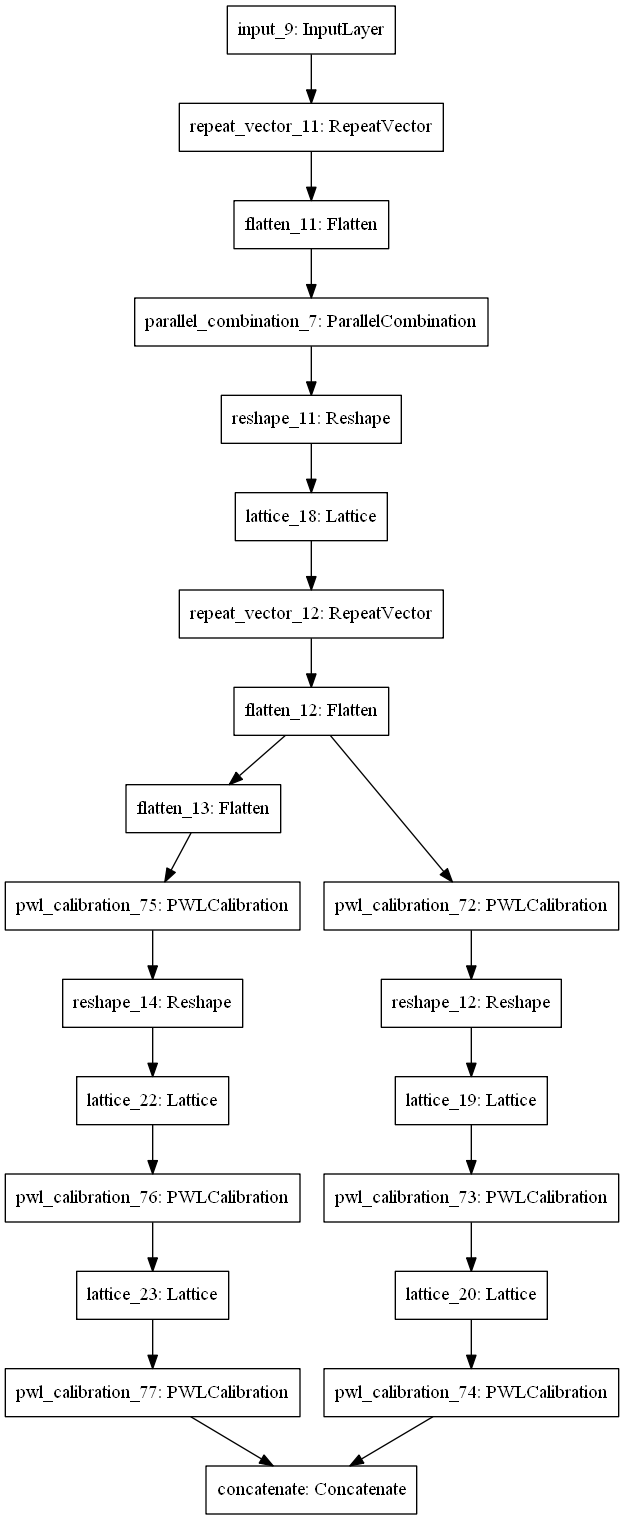

In [84]:
keras.utils.plot_model(model, "my_first_model.png")

In [85]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.fit(train_dataset.to_numpy(), train_labels.to_numpy(), epochs=50, validation_split=0.1, shuffle=False, callbacks=[callback])

Train on 7200 samples, validate on 800 samples
Epoch 1/50
7200/7200 [==============================] - 20s 3ms/sample - loss: 8190.5601 - mean_absolute_percentage_error: 37657912.0000 - val_loss: 6131.5860 - val_mean_absolute_percentage_error: 47655276.0000
Epoch 2/50
7200/7200 [==============================] - 3s 446us/sample - loss: 5399.8432 - mean_absolute_percentage_error: 19505350.0000 - val_loss: 4080.1694 - val_mean_absolute_percentage_error: 13115136.0000
Epoch 3/50
7200/7200 [==============================] - 3s 442us/sample - loss: 3647.2745 - mean_absolute_percentage_error: 12982055.0000 - val_loss: 2752.4989 - val_mean_absolute_percentage_error: 14484230.0000
Epoch 4/50
7200/7200 [==============================] - 3s 449us/sample - loss: 2482.6024 - mean_absolute_percentage_error: 12377804.0000 - val_loss: 1873.1886 - val_mean_absolute_percentage_error: 12351128.0000
Epoch 5/50
7200/7200 [==============================] - 3s 446us/sample - loss: 1701.1715 - mean_absolute_

Text(0.5, 1.0, 'vf')

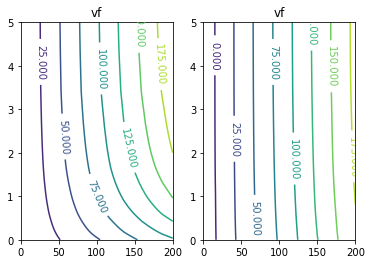

In [86]:
lattice_pred = np.zeros_like(ww)
lattice_pred2 = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        pred = model.predict_on_batch(obs[None,:]).numpy()
        lattice_pred[j, i] = pred[0][0]
        lattice_pred2[j, i] = pred[0][1]
fig, ax = plt.subplots(ncols=2, nrows=1)

CS = ax[0].contour(ww, ll, lattice_pred)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('vf')
CS = ax[1].contour(ww, ll, lattice_pred2)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('vf')

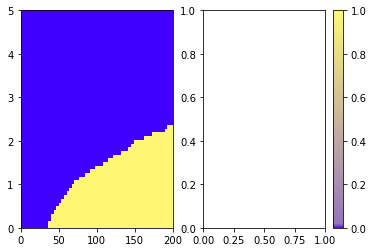

In [87]:
def plot_policy():
    w_points = 60
    l_points = 60
    l = np.linspace(0, 5, l_points)
    w = np.linspace(0, 200, w_points)
    ww, ll = np.meshgrid(w, l)
    z = np.zeros_like(ww)
    p = np.zeros_like(ww)
    for i, xp in enumerate(w):
        for j, yp in enumerate(l):
            fixed_obs = np.array([yp, xp])
            z[j, i] = np.argmax(model.predict_on_batch(fixed_obs[None, :]).numpy().flatten())

    fig, ax = plt.subplots(nrows=1, ncols=2)
    im = ax[0].pcolor(ww, ll, z)
    cdict = {
        'red': ((0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
        'green': ((0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
        'blue': ((0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
    }

    cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)
    im = ax[0].pcolor(ww, ll, z, cmap=cm)
    fig.colorbar(im)



plot_policy()